# Generación de datos sintéticos de radar metereológico sobremuestreado en rango

## Objetivos:

### Parte a)
* Generar datos sintéticos de radar meteorológico correlacionados en rango.
* Generar correlación en sample-time debido a fenómenos atmósfericos a los datos correlacionados en rango.
### Parte b)
* Blanquear en rango los datos sintetizados en $a)$ utilizando la transformación de blanqueo. 
* Calcular los estimadores espectrales para un sistema con pulso rectangular ideal, de duración $\tau$, y receptor con ancho de banda infinito, $h(l)= \delta (l)$.


In [36]:
import numpy as np
from matplotlib import pyplot as plt 


L= 8  # Factor de oversampling
F= 1   # Largo de la respuesta del filtro receptor
M= 256 # Cantidad de pulsos 
h_l= np.ones(F)  # Filtro receptor, una delta en nuestro caso ideal
p_l= np.ones(L) # L muestras del PULSO RECTANGULAR 
S = 10 # Potencia media de la señal de meteorológica, en dBm
sigma_v = 3 # Ancho de banda Doppler, en m/s
v_amax = 32 # Max velocidad ambigüa, en m/s
v_mean = 10 # Velocidad Doppler media, en m/s
Pn = -10  # Potencia de ruido, en dBm
lamb= 0.1 # Frecuencia de operanción, en m 


# Expresamos las potencias en veces

S= 10**((S-30)/10)
Pn= 10**((Pn-30)/10)


# Genero la la contribución de voltajes sq, IID CN(0,1).

sq= np.random.normal(0, 1/np.sqrt(2), size=(2*L+F-1, M)) + \
   1j*np.random.normal(0, 1/np.sqrt(2), size=(2*L+F-1, M)) 

# Generamos la correlación en rango

V_1= np.zeros((L, M),dtype = 'complex_')

for j in range(M):
    for i in range(L):
        V_1[i,j]= np.dot(sq[i:i+L,j],np.flip(p_l))

# Convolucionamos con el receptor (importante para el caso de receptor no ideal)

V_2= np.zeros((L+F-1,M), dtype= 'complex_') # Tiene el largo de V1 + H_l - 1

for k in range(M):

        V_2[:,k]= np.convolve( V_1[:,k], h_l, "full")

# Hago un reshape para borrar el transitorio y me quedo con los L valores de interes

V_2= V_2[-L:]

# Potencia media de la señal luego de agregar correlación en rango

G= sum(np.absolute(np.convolve(h_l, p_l, 'full'))**2)

# Generamos la correlación en tiempo, coloreo de espectro.

k= np.arange(-M, 2*M, 1, dtype=int) 

v_k= -v_amax + 2*k*v_amax/M # Vector que recorre desde -3Vamax a 3Vamax, para el aliasing

Pow_sepec= S*2*v_amax/(np.sqrt(2*np.pi)*sigma_v*G) *np.exp((-1*(v_k-v_mean)**2)/(2*sigma_v**2)) # Espectro Gaussiano

# Efecto de aliasing

Pw_spec = np.zeros(v_k.shape)

for ii in range(3):
    Pw_spec += np.roll(Pow_sepec, M*(ii-4))


Pw= Pw_spec[M:2*M]  # intervalo de Nyquist, de -Vamb a Vamb

Pw_sqrt= np.sqrt(Pw[::-1]) # Hago un flip para cambiar al eje de frecuencias.

# Reshape del vector
Pw_sqrt1= Pw_sqrt[int(M/2):] 
Pw_sqrt2= Pw_sqrt[0:int(M/2)] 

Pw_sqrt= np.concatenate((Pw_sqrt1,Pw_sqrt2),axis= None)

# Aplico la Transformada de Fourier a los datos con correlación en rango y coloreo.

V_2_f= np.zeros((L, M), dtype = 'complex_')
V= np.zeros((L, M), dtype = 'complex_')

for j in range(L):
    V_2_f [j, :] = np.fft.fft(V_2[j, :])


for j in range(L):    
    V[j, :]= np.fft.ifft( V_2_f[j,:] * Pw_sqrt)  # V tiene la correlación en rango y tiempo.


# Agregamos ruido de potencia Pn

V += (   np.random.normal(0, 1, (L,M)) + \
          1j*np.random.normal(0, 1, (L,M)) )*np.sqrt(Pn/2)







In [37]:
# BLANQUEO EN RANGO

import numpy as np
from matplotlib import pyplot as plt 


ro= np.zeros(L)
ro= np.convolve(p_l,np.conjugate(np.flip(p_l)), "full")/(np.sum(p_l**2)) # Coeficientes de correlación

# Encuentro la matriz de correlación C_v^R

U= np.zeros((L, L), dtype= 'complex_')
U_conj= np.zeros((L, L), dtype= 'complex_')
for mm in range(L):     
        U[mm,:]= U[mm,:] + np.roll(ro[-L:], mm)
 
U= np.triu(U, 0)
U_h= np.matrix.transpose(U)
U_h= np.tril( U_h, -1)

C_vR= U + np.conjugate(U_h)  # Matriz de correlación

# Descomponemos C_v^R y encontramos la matriz de blanqueo

H= np.linalg.cholesky(C_vR) # Descomposición de Cholesky

W= np.linalg.inv(H) # Matriz de transformación de blanqueo

X= np.dot(W, V) # Datos blanqueados




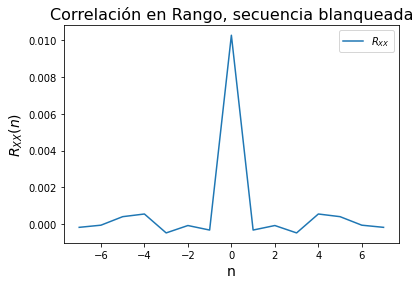

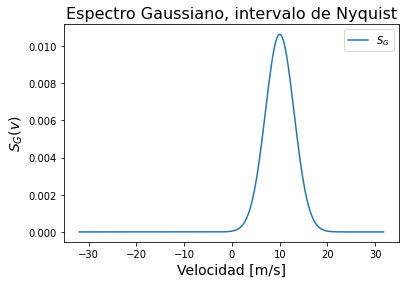

In [38]:
# Gráficas para chequear resultados:
import numpy as np
from matplotlib import pyplot as plt 

x= np.arange(-L+1, L)
x2=np.arange(-M+1, M)


y= np.zeros(2*L-1, dtype= 'complex_')

for i in range(M):
    y += 1/(L*M) * np.correlate(V[:,i], V[:,i], "full") # Correlación en Rango sin traf. de blanqueo

y2= np.zeros(2*L-1, dtype= 'complex_')

for i in range(M):
    y2 += 1/(L*M) * np.correlate(X[:,i], X[:,i], "full") # Correlación en Rango sin traf. de blanqueo


x= np.arange(-L+1, L)


# Correlación sin blanqueo
plt.figure(0)
plt.plot(x, np.real(y), label='$R_{VV}$')
plt.legend()
plt.title('Correlación en Rango, secuencia sin blanqueo', fontdict= {'size': 16})
plt.xlabel('n', fontdict= {'size': 14})
plt.ylabel('$R_{VV}(n)$', fontdict= {'size': 14})
plt.show()

# Correlación con blanqueo
plt.figure(1)
plt.plot(x, np.real(y2), label='$R_{XX}$')
plt.legend()
plt.title('Correlación en Rango, secuencia blanqueada', fontdict= {'size': 16})
plt.xlabel('n', fontdict= {'size': 14})
plt.ylabel('$R_{XX}(n)$', fontdict= {'size': 14})
plt.show()

# Espectro Gaussiano y efecto de aliasing

plt.figure(2)
plt.plot(v_k,Pw_spec, label='$S_{G}$') # Espectro con aliasing
plt.legend()
plt.title('Espectro Gaussiano con efecto de aliasing', fontdict= {'size': 16})
plt.xlabel('Velocidad [m/s]', fontdict= {'size': 14})
plt.ylabel('$S_{G}(v)$', fontdict= {'size': 14})
plt.show()

# Intervalo de Nyquist, de -Vamb a Vamb

Vel= v_k[M:2*M]

plt.figure(3)
plt.plot(Vel,Pw, label='$S_{G}$') # Espectro con aliasing
plt.legend()
plt.title('Espectro Gaussiano, intervalo de Nyquist', fontdict= {'size': 16})
plt.xlabel('Velocidad [m/s]', fontdict= {'size': 14})
plt.ylabel('$S_{G}(v)$', fontdict= {'size': 14})
plt.show()

# Periodograma

Fs= 4*v_amax / lamb  # Frecuencia de muestro
Ts= 1/Fs  # Tiempo de muestro
Sx= np.zeros(M)
for j in range(L):
    Sx +=1/L * np.abs(np.fft.fftshift(np.fft.fft(V[j,:])))**2 * Ts/M # Densidad espectral
Sx = 10*np.log10(Sx)
freq = np.arange(-M/2, M/2, 1)*-2*v_amax/M # Freq [Hz]

# Plot del periodograma
plt.figure(4)
plt.plot(freq,Sx, label='$S_{XX}$')
plt.legend()
plt.title('Periodograma', fontdict= {'size': 16})
plt.xlabel('Velocidad [m/s]', fontdict= {'size': 14})
plt.ylabel('$S_{XX}[dB]$', fontdict= {'size': 14})
plt.show()


In [39]:
# Estimadores espectrales

import numpy as np
from matplotlib import pyplot as plt 

# Noise enhancement factor (NEF)

NEF= 1/L * np.trace(np.linalg.inv(C_vR))

# Estimador de potencia

S_est= 0
for i in range(L):
    for j in range(M):
        S_est += 1/(M*L) * np.absolute(X[i,j])**2 

S_est = S_est - Pn*NEF
# Estimador de autocorrelación en lag=1
Rx_1= np.zeros(1, dtype= 'complex_') 
for j in range(L):
    for i in range(M-1):
         Rx_1 += 1/(L*(M-1)) *np.conjugate(X[j,i])*X[j,i+1]

# Estimador de velocidad Doppler

V_doppler= -v_amax/np.pi * np.arctan2(Rx_1.imag, Rx_1.real)


# Estimador del ancho de banda Doppler

sigma_v_est= v_amax*np.sqrt(2)/np.pi * np.sqrt(np.log(S_est/np.abs(Rx_1))) * np.sign(np.log(S_est/np.abs(Rx_1)))

# Relación señal a ruido
SNR= 10*np.log10(S/Pn)


print("La SNR [dB] es:", SNR)
print("La potencia media de la señal blanqueada es:",S_est.real)
print("La potencia media de la señal:", S)
print("La velocidad Doppler estimada es:", V_doppler)
print("Velocidad Doppler:", v_mean)
print("El ancho de banda Doppler estimado es:",sigma_v_est.real)
print("Ancho de banda Doppler:",sigma_v)

La SNR [dB] es: 20.0
La potencia media de la señal blanqueada es: 0.009571886564234598
La potencia media de la señal: 0.01
La velocidad Doppler estimada es: [10.18731174]
Velocidad Doppler: 10
El ancho de banda Doppler estimado es: [3.02258822]
Ancho de banda Doppler: 3


In [40]:
# Potencia de la señal mediante integración de la DEP
Sx = 10**(Sx/10) # Expresamos en veces la DEP
potencia_estimada_por_DEP= np.sum(Sx*Fs/M)
print(potencia_estimada_por_DEP)








0.009772339960261618
